In [4]:
pip install shap

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/545.3 kB ? eta -:--:--
   ---------------------------------------- 545.3/545.3 kB 3.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64
         Contract  total_customers  avg_monthly_charges  avg_tenure  \
0  Month-to-month             3875            66.398490   18.036645   
1        One year             1472            65.079416   42.073370   
2        Two year             1685            60.872374   57.071810   

   churned_customers  
0               1655  
1                166  
2                 48  


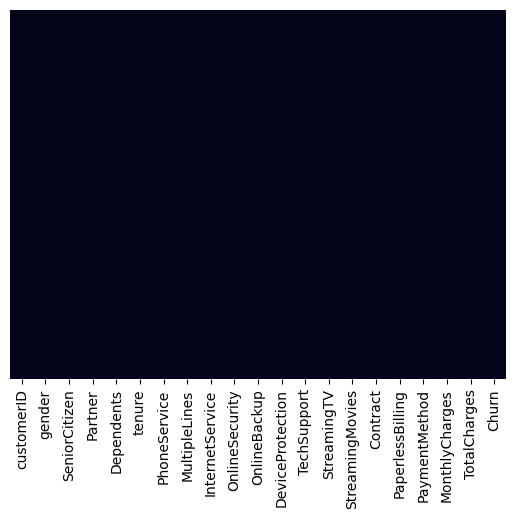

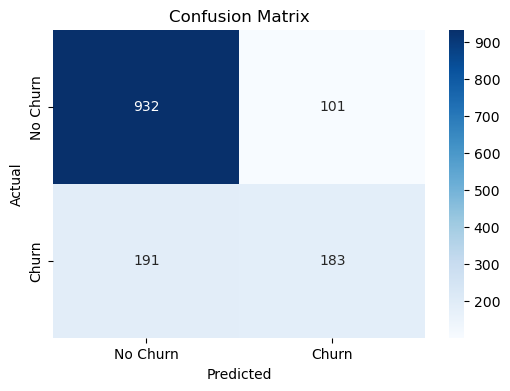

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.90      0.86      1033
           1       0.64      0.49      0.56       374

    accuracy                           0.79      1407
   macro avg       0.74      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407



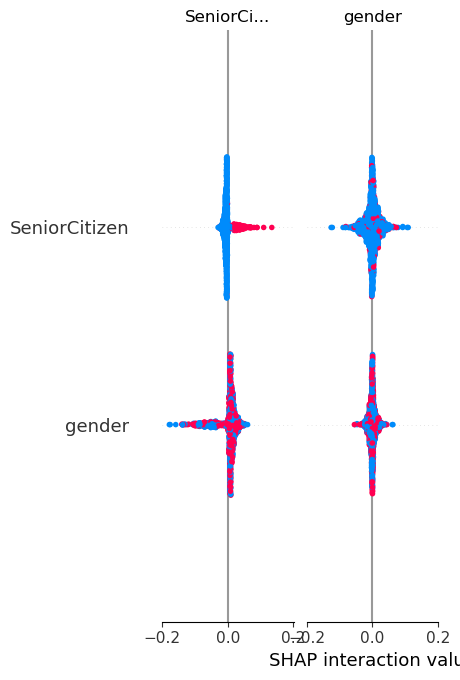

Customer segments are saved to 'Segmented_Customers.csv'


In [8]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import shap
df = pd.read_csv(r'C:\Users\l\OneDrive\Desktop\Customer.csv')

#Cleaning  & Converting TotalCharges to float safely
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors='coerce')

#To check the count of null values 
print(df.isnull().sum()) 

#Visualizing Null Values using Heat Ma
sns.heatmap(df.isnull(),yticklabels=False,cbar=False) 

# Dropinng rows with missing TotalCharges
df = df.dropna(subset=["TotalCharges"])

#SQL Aggregation
conn = sqlite3.connect(":memory:")
df.to_sql("customers", conn, index=False, if_exists="replace")

query = """
SELECT 
    Contract,
    COUNT(*) AS total_customers,
    AVG(MonthlyCharges) AS avg_monthly_charges,
    AVG(tenure) AS avg_tenure,
    SUM(CASE WHEN Churn='Yes' THEN 1 ELSE 0 END) AS churned_customers
FROM customers
GROUP BY Contract
ORDER BY churned_customers DESC
"""
sql_result = pd.read_sql_query(query, conn)
print(sql_result)

#Encoding Categorical Columns
le = LabelEncoder()
for col in df.select_dtypes(include="object"):
    if col != "customerID":
        df[col] = le.fit_transform(df[col])

#Train/Test Split
X = df.drop(["customerID", "Churn"], axis=1)
y = df["Churn"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Churn", "Churn"], yticklabels=["No Churn", "Churn"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Explainer for the tree model using SHAP
explainer = shap.TreeExplainer(model)

# Geting SHAP values for all classes (binary: [0] = no churn, [1] = churn)
shap_values = explainer.shap_values(X_test)

#Plotting SHAP values 
if isinstance(shap_values, list) and len(shap_values) == 2:
    shap.summary_plot(shap_values[1], X_test)
else:
    shap.summary_plot(shap_values, X_test)

#Customer Segmentation (Results can be seen on the newly uddated csv file)
df["Churn_Predicted"] = model.predict(X)

conditions = [
    (df["Churn_Predicted"] == 1) & (df["MonthlyCharges"] > df["MonthlyCharges"].mean()),
    (df["Churn_Predicted"] == 0) & (df["tenure"] > 24),
    (df["MonthlyCharges"] < df["MonthlyCharges"].mean()) & (df["tenure"] < 6)
]
choices = ["At Risk", "Loyal", "Dormant"]

df["Segment"] = pd.cut(df["tenure"], bins=[0, 6, 24, df["tenure"].max()], labels=["Dormant", "At Risk", "Loyal"])

# Saving the file
df[["customerID", "MonthlyCharges", "tenure", "Churn_Predicted", "Segment"]].to_csv("Segmented_Customers.csv", index=False)
print("Customer segments are saved to 'Segmented_Customers.csv'")
